In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import igraph as ig
import gravis as gv
import networkx as nx
#import leidenalg as la

from matplotlib import rc
from functions import clean_address, es_diagonal_cero, propiedades, centralidades, centralizacion

In [38]:
dfa = pd.read_excel("../Datasets/Research_status_2017_2022.xlsx")

In [39]:
top = ['Multidisciplinary', 'Particles & Fields', 'Applied', 'Condensed Matter', 'Mathematical', 'Molecular & Chemical', 'Physical', 'Astronomy & Astrophysics', 'Fluids & Plasmas']
anios = [2017, 2018, 2019, 2020, 2021, 2022]

## Todos los años

In [40]:
dfe = dfa.copy()
dfe = dfe[['Language', 'Affiliations', 'Document Type', 'Addresses', 'Publication Year', 'WoS Categories']]
dfe = dfe.dropna(subset = ['Addresses', 'Affiliations'])
dfe = dfe[dfe['Document Type']=='Article']
dfe = dfe[dfe['Publication Year']<2023]
dfe["Addresses"] = dfe["Addresses"].apply(lambda x: re.sub(r'\[.*?\]', '', x))
dfe['Addresses'] = dfe['Addresses'].apply(lambda x: x + ';')
dfe['Countries'] = dfe['Addresses'].apply(lambda x: '; '.join(re.findall(r', ([A-Z][a-z]+);', x)))
pattern = re.compile(r'USA|Peoples R China|BELARUS|Korea|Czech Republic|U Arab Emirates|South Africa|Ireland')

dfe = dfe[~dfe['Addresses'].str.contains(r', [A-Z][a-z]+ [A-Z][a-z]+;', regex=True)]
dfe = dfe[~dfe['Addresses'].str.contains(pattern)]
dfe['Paises'] = dfe['Countries'].apply(clean_address)
dfe['Categorias'] = dfe['WoS Categories'].apply(clean_address)
dfe['Type'] = dfe['Document Type'].apply(clean_address)

dfe = dfe[dfe['Categorias'].apply(lambda x: all(item in top for item in x))]
dfe = dfe[dfe['Paises'].apply(lambda x: len(x) == 1 and x[0] == 'Chile')]


In [41]:
dfAll = dfe
dfAll['Instituciones'] = dfAll['Affiliations'].str.split(';', expand=False)
dfAll['Instituciones'] = dfAll['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfAll['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfAll['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adjAll = adj_matrix.to_numpy()
adjAll = adjAll.astype(float)

InstA = nx.Graph()

for countries in dfAll['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                InstA.add_edge(countries[i], countries[j], weight=adjAll[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(InstA)
nx.set_node_attributes(InstA, c, 'betweenness')


fig = gv.d3(InstA, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

print(len(all_inst))

43


In [42]:
print(propiedades(InstA))

Graph with 43 nodes and 236 edges
N de Nodos:  43
N de aristas:  236
Es direccionado:  False
Transitividad 0.49137931034482757
Centralización  0.010121121619379458
Tiene:  4 comunidades
[frozenset({'Universidad del Bio-Bio', "Universidad  Bernardo O'Higgins", 'Universidad Autonoma de Chile', 'Universidad Internacional SEK', 'Universidad de Antofagasta', 'Universidad de Vina del Mar', 'INACAP', 'Universidad de Talca', 'Universidad Catolica Silva Henriquez', 'Instituto de Fomento Pesquero (Valparaiso)', 'Universidad de Las Americas - Chile', 'Universidad Andres Bello', 'Universidad Catolica del Norte', 'Pontificia Universidad Catolica de Chile', 'Universidad del Desarrollo'}), frozenset({'Universidad de Santiago de Chile', 'Universidad de Playa Ancha', 'Universidad de Chile', 'Centre National de la Recherche Scientifique (CNRS)', 'Universidad Austral de Chile', 'Universidad Catolica del Maule', 'Universidad Tecnica Federico Santa Maria', 'CNRS - National Institute for Mathematical Scienc

### 2017

In [43]:
dfe2017 = dfe[dfe['Publication Year']==2017].copy()
dfe2017['Instituciones'] = dfe2017['Affiliations'].str.split(';', expand=False)
dfe2017['Instituciones'] = dfe2017['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2017['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2017['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2017 = nx.Graph()

for countries in dfe2017['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            graph2017.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])



c = nx.algorithms.degree_centrality(graph2017)
nx.set_node_attributes(graph2017, c, 'betweenness')


labels = {node: node for node in graph2017.nodes()}
fig = gv.d3(graph2017, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

print(len(all_inst))

centr2017 = centralidades(graph2017)
cent_grado = centr2017['centralidad'].head(20)
centralizacion2017 = centralizacion(graph2017)
densidad2017 = nx.density(graph2017)
asort2017 = nx.degree_assortativity_coefficient(graph2017)
trans2017 = nx.transitivity(graph2017)

32


In [44]:
print(propiedades(graph2017))

Graph with 31 nodes and 73 edges
N de Nodos:  31
N de aristas:  73
Es direccionado:  False
Transitividad 0.3942857142857143
Centralización  0.01459770114942529
Tiene:  6 comunidades
[frozenset({"Universidad  Bernardo O'Higgins", 'Universidad Autonoma de Chile', 'Universidad Catolica del Maule', 'Universidad de Antofagasta', 'INACAP', 'Universidad de Talca', 'Universidad de Las Americas - Chile', 'Pontificia Universidad Catolica de Chile', 'Universidad Andres Bello'}), frozenset({'Universidad de Concepcion', 'Universidad de los Andes - Chile', 'Universidad del Bio-Bio', 'Universidad de La Frontera', 'Universidad San Sebastian'}), frozenset({'Universidad de Santiago de Chile', 'Universidad Tecnica Federico Santa Maria', 'Universidad de Valparaiso', 'Pontificia Universidad Catolica de Valparaiso', 'Universidad de Atacama'}), frozenset({'Universidad Catolica de Temuco', 'Universidad de Tarapaca', 'University Diego Portales', 'Universidad de La Serena'}), frozenset({'Universidad de Chile', 

### 2018

In [45]:
dfe2018 = dfe[dfe['Publication Year']==2018].copy()
dfe2018['Instituciones'] = dfe2018['Affiliations'].str.split(';', expand=False)
dfe2018['Instituciones'] = dfe2018['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2018['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2018['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2018 = nx.Graph()

for countries in dfe2018['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2018.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2018)
nx.set_node_attributes(graph2018, c, 'betweenness')


labels = {node: node for node in graph2018.nodes()}
fig = gv.d3(graph2018, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2018 = centralidades(graph2018)
cent_grado = centr2018['centralidad'].head(20)
centralizacion2018 = centralizacion(graph2018)
densidad2018 = nx.density(graph2018)
asort2018 = nx.degree_assortativity_coefficient(graph2018)
trans2018 = nx.transitivity(graph2018)

In [46]:
print(propiedades(graph2018))

Graph with 34 nodes and 69 edges
N de Nodos:  34
N de aristas:  69
Es direccionado:  False
Transitividad 0.31528662420382164
Centralización  0.007747933884297519
Tiene:  5 comunidades
[frozenset({'Universidad de Santiago de Chile', 'Universidad de los Andes - Chile', 'Universidad de Chile', 'Universidad Austral de Chile', 'Centre National de la Recherche Scientifique (CNRS)', 'Universidad Tecnica Federico Santa Maria', 'CNRS - National Institute for Mathematical Sciences (INSMI)', 'Universidad de Valparaiso', "Universidad de O'Higgins", 'Universidad Andres Bello', 'Universidad San Sebastian'}), frozenset({'Universidad de Antofagasta', 'INACAP', 'Universidad de Las Americas - Chile', 'University Diego Portales', 'Universidad de Tarapaca', 'Universidad Catolica de Temuco', 'Universidad de La Serena'}), frozenset({'Universidad Adolfo Ibanez', "Universidad  Bernardo O'Higgins", 'Universidad del Bio-Bio', 'Universidad de La Frontera', 'Universidad Catolica de la Santisima Concepcion', 'Pont

### 2019

In [47]:
dfe2019 = dfe[dfe['Publication Year'] == 2019].copy()
dfe2019['Instituciones'] = dfe2019['Affiliations'].str.split(';', expand=False)
dfe2019['Instituciones'] = dfe2019['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2019['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2019['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2019 = nx.Graph()

for countries in dfe2019['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2019.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2019)
nx.set_node_attributes(graph2019, c, 'betweenness')


labels = {node: node for node in graph2019.nodes()}
fig = gv.d3(graph2019, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2019 = centralidades(graph2019)
cent_grado = centr2019['centralidad'].head(20)
centralizacion2019 = centralizacion(graph2019)
densidad2019 = nx.density(graph2019)
asort2019 = nx.degree_assortativity_coefficient(graph2019)
trans2019 = nx.transitivity(graph2019)

In [48]:
print(propiedades(graph2019))

Graph with 30 nodes and 67 edges
N de Nodos:  30
N de aristas:  67
Es direccionado:  False
Transitividad 0.362962962962963
Centralización  0.012145405129947343
Tiene:  4 comunidades
[frozenset({'Universidad Tecnologica Metropolitana', 'Universidad del Bio-Bio', 'Universidad Arturo Prat', 'Universidad Autonoma de Chile', 'Universidad de Chile', 'Universidad Catolica del Maule', 'Universidad de Talca', 'Universidad de Tarapaca', 'Pontificia Universidad Catolica de Chile', 'Universidad San Sebastian', 'Universidad del Desarrollo'}), frozenset({'Universidad Adolfo Ibanez', 'Universidad de Santiago de Chile', 'Universidad Finis Terrae', 'Universidad de Valparaiso', 'Pontificia Universidad Catolica de Valparaiso', 'Universidad de La Frontera', 'Universidad Central de Chile'}), frozenset({'Universidad de Antofagasta', "Universidad  Bernardo O'Higgins", 'INACAP', 'Universidad de Las Americas - Chile', 'Universidad Andres Bello', 'Universidad Catolica de Temuco'}), frozenset({'Universidad de Co

### 2020

In [49]:
dfe2020 = dfe[dfe['Publication Year']==2020].copy()
dfe2020['Instituciones'] = dfe2020['Affiliations'].str.split(';', expand=False)
dfe2020['Instituciones'] = dfe2020['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2020['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2020['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2020 = nx.Graph()

for countries in dfe2020['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2020.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2020)
nx.set_node_attributes(graph2020, c, 'betweenness')


labels = {node: node for node in graph2020.nodes()}
fig = gv.d3(graph2020, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2020 = centralidades(graph2020)
cent_grado = centr2020['centralidad'].head(20)
centralizacion2020 = centralizacion(graph2020)
densidad2020 = nx.density(graph2020)
asort2020 = nx.degree_assortativity_coefficient(graph2020)
trans2020 = nx.transitivity(graph2020)

In [50]:
print(propiedades(graph2020))

Graph with 33 nodes and 61 edges
N de Nodos:  33
N de aristas:  61
Es direccionado:  False
Transitividad 0.2785714285714286
Centralización  0.008631552419354838
Tiene:  5 comunidades
[frozenset({'Universidad Tecnologica Metropolitana', "Universidad  Bernardo O'Higgins", 'Universidad de Santiago de Chile', 'Universidad Mayor', 'Universidad de Chile', 'Universidad Catolica del Maule', 'Universidad de Talca', 'Universidad de La Frontera', "Universidad de O'Higgins", 'Pontificia Universidad Catolica de Chile'}), frozenset({'Universidad Adolfo Ibanez', 'Universidad Catolica de la Santisima Concepcion', 'Universidad de Antofagasta', 'Universidad Tecnica Federico Santa Maria', 'Universidad Catolica Silva Henriquez', 'Universidad Andres Bello', 'Universidad Catolica del Norte', 'Universidad del Desarrollo'}), frozenset({'Universidad del Bio-Bio', 'University Diego Portales', 'Instituto de Fomento Pesquero (Valparaiso)', 'Universidad de Tarapaca', 'Universidad Catolica de Temuco', 'Universidad 

### 2021


In [51]:
dfe2021 = dfe[dfe['Publication Year']==2021].copy()
dfe2021['Instituciones'] = dfe2021['Affiliations'].str.split(';', expand=False)
dfe2021['Instituciones'] = dfe2021['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2021['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2021['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2021 = nx.Graph()

for countries in dfe2021['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2021.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2021)
nx.set_node_attributes(graph2021, c, 'betweenness')


labels = {node: node for node in graph2021.nodes()}
fig = gv.d3(graph2021, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2021 = centralidades(graph2021)
cent_grado = centr2021['centralidad'].head(20)
centralizacion2021 = centralizacion(graph2021)
densidad2021 = nx.density(graph2021)
asort2021 = nx.degree_assortativity_coefficient(graph2021)
trans2021 = nx.transitivity(graph2021)


In [52]:
print(propiedades(graph2021))

Graph with 35 nodes and 93 edges
N de Nodos:  35
N de aristas:  93
Es direccionado:  False
Transitividad 0.27318718381112983
Centralización  0.008886442277445738
Tiene:  5 comunidades
[frozenset({'Universidad Tecnologica Metropolitana', "Universidad  Bernardo O'Higgins", 'Universidad Autonoma de Chile', 'Universidad Catolica de la Santisima Concepcion', 'Universidad Internacional SEK', 'Universidad de Antofagasta', 'Universidad de Vina del Mar', 'Pontificia Universidad Catolica de Chile', 'Universidad Andres Bello'}), frozenset({'Universidad Adolfo Ibanez', 'Universidad de los Andes - Chile', 'Universidad Finis Terrae', 'Universidad de Valparaiso', 'Universidad de Playa Ancha', 'Universidad Mayor', 'University Diego Portales'}), frozenset({'Universidad de Concepcion', 'Universidad Tecnica Federico Santa Maria', 'Universidad de La Frontera', 'Universidad de Chile', 'Universidad Austral de Chile', 'Universidad de Tarapaca', 'Universidad de Atacama'}), frozenset({'Universidad del Bio-Bio'

### 2022

In [53]:
dfe2022 = dfe[dfe['Publication Year']==2022].copy()
dfe2022['Instituciones'] = dfe2022['Affiliations'].str.split(';', expand=False)
dfe2022['Instituciones'] = dfe2022['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2022['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2022['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2022 = nx.Graph()

for countries in dfe2022['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2022.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2022)
nx.set_node_attributes(graph2022, c, 'betweenness')


labels = {node: node for node in graph2022.nodes()}
fig = gv.d3(graph2022, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)


centr2022 = centralidades(graph2022)
cent_grado = centr2022['centralidad'].head(20)
centralizacion2022 = centralizacion(graph2022)
densidad2022 = nx.density(graph2022)
asort2022 = nx.degree_assortativity_coefficient(graph2022)
trans2022 = nx.transitivity(graph2022)

In [54]:
print(propiedades(graph2022))

Graph with 33 nodes and 93 edges
N de Nodos:  33
N de aristas:  93
Es direccionado:  False
Transitividad 0.34142640364188165
Centralización  0.009734122983870967
Tiene:  4 comunidades
[frozenset({'Universidad Autonoma de Chile', 'Universidad Austral de Chile', 'Universidad Catolica de Temuco', 'Universidad de Antofagasta', 'Universidad Tecnica Federico Santa Maria', 'Universidad de Las Americas - Chile', 'Universidad Andres Bello', 'Universidad San Sebastian', 'Universidad Catolica del Norte'}), frozenset({'Universidad de Concepcion', 'Universidad de Santiago de Chile', 'Universidad Adolfo Ibanez', 'Universidad de los Andes - Chile', 'Universidad Catolica de la Santisima Concepcion', 'Universidad de Chile', 'Universidad Catolica del Maule', 'Universidad Central de Chile', 'Universidad de Atacama'}), frozenset({'Universidad de Vina del Mar', 'Universidad Tecnologica Metropolitana', 'Universidad Finis Terrae', 'Universidad Mayor', "Universidad  Bernardo O'Higgins", 'Universidad del Bio-B

## Series de tiempo

### Densidad

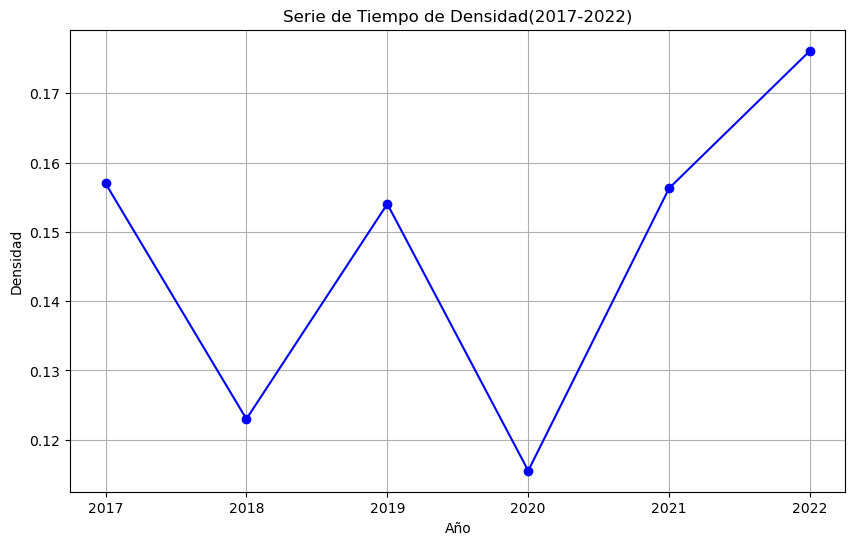

In [55]:
densidad_anio = [densidad2017, densidad2018, densidad2019, densidad2020, densidad2021, densidad2022]

df_densidad = pd.DataFrame({
    "Año": anios,
    "Densidad": densidad_anio})
df_densidad

df_densidad.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_densidad.index, df_densidad['Densidad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Densidad')
plt.title('Serie de Tiempo de Densidad(2017-2022)')
plt.grid(True)
plt.show()

### Centralización

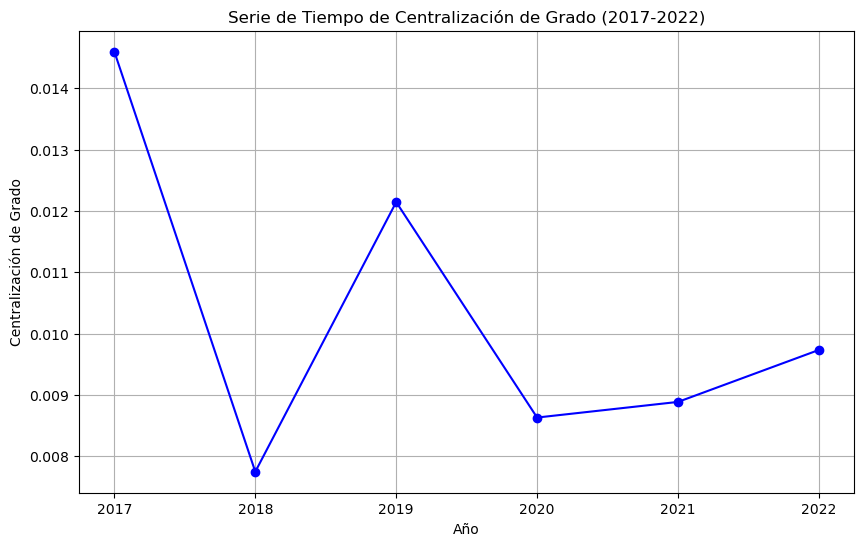

In [56]:
centralizacion_anio = [centralizacion2017, centralizacion2018, centralizacion2019, centralizacion2020, centralizacion2021, centralizacion2022]

df_centralizacion = pd.DataFrame({
    'Año': anios,
    'Centralización de Grado': centralizacion_anio})
df_centralizacion

df_centralizacion.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_centralizacion.index, df_centralizacion['Centralización de Grado'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Centralización de Grado')
plt.title('Serie de Tiempo de Centralización de Grado (2017-2022)')
plt.grid(True)
plt.show()

### Asortatividad

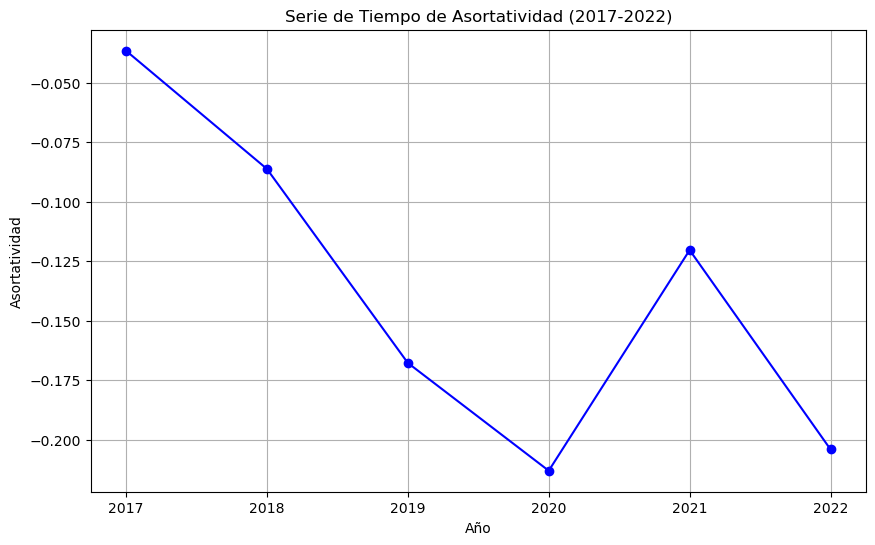

In [57]:
asort_anio = [asort2017, asort2018, asort2019, asort2020, asort2021, asort2022]

df_asort = pd.DataFrame({
    'Año': anios,
    'Asortatividad': asort_anio})

df_asort.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_asort.index, df_asort['Asortatividad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Asortatividad')
plt.title('Serie de Tiempo de Asortatividad (2017-2022)')
plt.grid(True)
plt.show()

### Transitividad

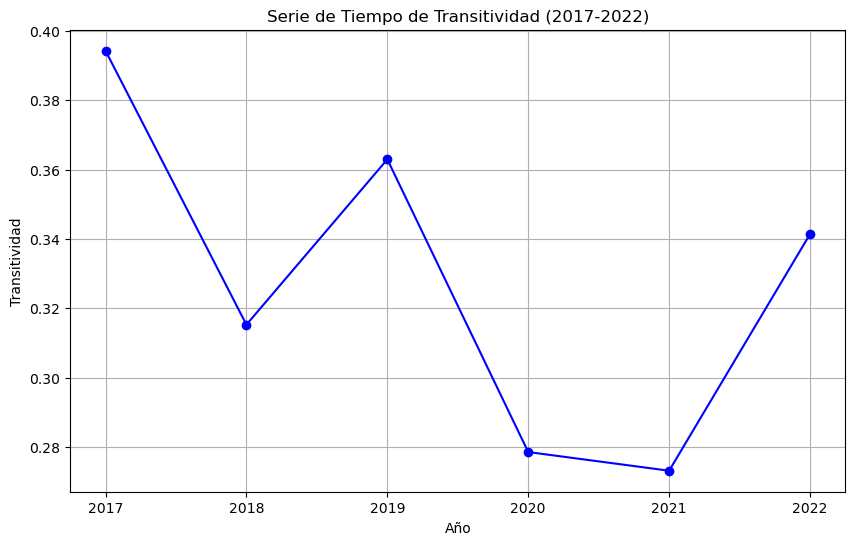

In [58]:
trans_anio = [trans2017, trans2018, trans2019, trans2020, trans2021, trans2022]

df_asort = pd.DataFrame({
    'Año': anios,
    'Transitividad': trans_anio})

df_asort.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_asort.index, df_asort['Transitividad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Transitividad')
plt.title('Serie de Tiempo de Transitividad (2017-2022)')
plt.grid(True)
plt.show()

### Comparación métricas


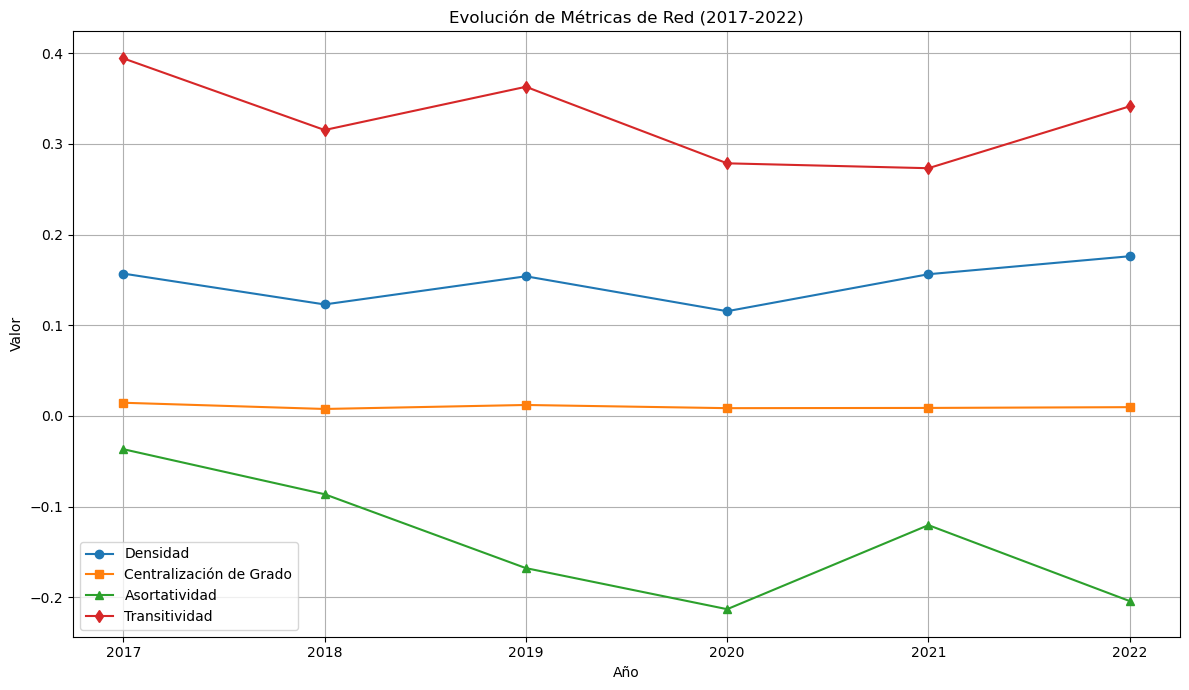

In [59]:
df = pd.DataFrame({
    'Año': anios,
    'Densidad': densidad_anio,
    'Centralización de Grado': centralizacion_anio,
    'Asortatividad': asort_anio,
    'Transitividad': trans_anio
})

df.set_index('Año', inplace=True)

plt.figure(figsize=(12, 7))
plt.plot(df.index, df['Densidad'], marker='o', label='Densidad')
plt.plot(df.index, df['Centralización de Grado'], marker='s', label='Centralización de Grado')
plt.plot(df.index, df['Asortatividad'], marker='^', label='Asortatividad')
plt.plot(df.index, df['Transitividad'], marker='d', label='Transitividad')

plt.xlabel('Año')
plt.ylabel('Valor')
plt.title('Evolución de Métricas de Red (2017-2022)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()